# Hearbet Sound Anomaly Detector - Training

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchaudio
import torchaudio.transforms as T
from torchvision import transforms
from torchmetrics import Accuracy, Precision
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import timm

from typing import Callable, Dict, List, Tuple

c:\Users\Erick\miniconda3\envs\heartbet-sound-anomaly-detector-py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [68]:
torch.__version__

'2.1.1+cu121'

In [69]:
torch.cuda.is_available()

True

## Creating Pandas dataframe

In [70]:
AUDIO_DIR = Path('../unzipped_data/')

def list_files():
    for file in AUDIO_DIR.glob('**/*.wav'):
        yield file.as_posix()

def create_dataframe():
    data_files = []
    for filename in list_files():
        if filename.find('artifact')>-1:
            data_files.append((filename, 'artifact'))
        if filename.find('extrahls')>-1:
            data_files.append((filename, 'extrahls'))
        if filename.find('extrastole')>-1:
            data_files.append((filename, 'extrastole'))
        if filename.find('murmur')>-1:
            data_files.append((filename, 'murmur'))
        if filename.find('normal')>-1:
            data_files.append((filename, 'normal'))

    return pd.DataFrame(data_files, columns=('fname', 'label'))

In [71]:
dataframe = create_dataframe()

## Custom Dataset and DataLoaders

In [72]:
__labels = dataframe.label.unique()
dict(zip(__labels, range(len(__labels))))

{'artifact': 0, 'extrahls': 1, 'murmur': 2, 'normal': 3, 'extrastole': 4}

In [18]:
class Preprocessing:

    @staticmethod
    def process_audio(file_name: str, target_sample_rate: int, num_samples: int) -> torch.Tensor:
        waveform, sample_rate = torchaudio.load(file_name)
        waveform = torch.mean(waveform, axis=0)

        if sample_rate != target_sample_rate:
            resampler = T.Resample(sample_rate, target_sample_rate)
            waveform = resampler(waveform)

        if waveform.shape[0] >= num_samples:
            waveform = waveform[:num_samples]
        else:
            waveform = F.pad(waveform, (0, num_samples - waveform.shape[0]))
        melspectrgoram = T.MelSpectrogram(n_fft = 128, n_mels = 128, hop_length = 128)
        melspec = melspectrgoram(waveform)
        return torch.stack([melspec])

In [74]:
class AudioDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, *, audio_length: float, target_sample_rate: int) -> None:
        self.__target_sample_rate = target_sample_rate
        self.__num_samples = target_sample_rate * audio_length
        self.__labels = dataframe['label'].values
        self.__filenames = dataframe['fname'].values
        self.__class_indices = {'artifact': 0, 'extrahls': 1, 'murmur': 2, 'normal': 3, 'extrastole': 4}

    def __len__(self):
        return len(self.__labels)

    def __getitem__(self, index) -> dict:

        melspec = Preprocessing.process_audio(self.__filenames[index], self.__target_sample_rate, self.__num_samples)

        label: str = self.__labels[index]

        class_idx = self.__class_indices[label]

        return melspec, class_idx

class AudioDatasetWithAugmentation(AudioDataset):
    def __init__(self, dataframe: pd.DataFrame, *, audio_length: float, target_sample_rate: int, transform = None) -> None:
        super().__init__(dataframe,
                         audio_length = audio_length,
                         target_sample_rate = target_sample_rate)

        self.__transform = transform

    def __getitem__(self, index) -> dict:
        melspec, class_idx = super().__getitem__(index)

        melspec = self.__transform(melspec)

        return melspec, class_idx

In [88]:
SEED: int = 42
AUDIO_LENGTH: int = 10
TARGET_SAMPLE_RATE: int = 4000

train_dataset_df, test_dataset_df = train_test_split(dataframe,
                                                     train_size = .7,
                                                     random_state = SEED,
                                                     shuffle = True,
                                                     stratify = dataframe.label)

train_params = {
    'dataframe': train_dataset_df,
    'audio_length': AUDIO_LENGTH,
    'target_sample_rate': TARGET_SAMPLE_RATE
}

test_params = {
    'dataframe': test_dataset_df,
    'audio_length': AUDIO_LENGTH,
    'target_sample_rate': TARGET_SAMPLE_RATE
}

## Dataset without augmentation

train_dataset = AudioDataset(**train_params)
test_dataset = AudioDataset(**test_params)

## Dataset with augmentation

transformation_classes = transforms.Compose([
    T.FrequencyMasking(freq_mask_param = 10),
    #T.TimeStretch(.8, fixed_rate = True),
    #T.TimeMasking(time_mask_param = 80)
])

MINORITY_CLASSES = 'extrastole', 'artifact', 'extrahls'

train_params.update({
    'dataframe': train_dataset_df[train_dataset_df.label.isin(MINORITY_CLASSES)],
})

test_params.update({
    'dataframe': test_dataset_df[test_dataset_df.label.isin(MINORITY_CLASSES)],
})

train_dataset_augmented = AudioDatasetWithAugmentation(**train_params, transform = transformation_classes)
test_dataset_augmented = AudioDatasetWithAugmentation(**test_params, transform = transformation_classes)

train_dataset_concatenated = ConcatDataset((train_dataset, train_dataset_augmented))
test_dataset_concatenated = ConcatDataset((test_dataset, test_dataset_augmented))

In [76]:
print(train_dataset[0][0].shape)
print('Lenght of train dataset', len(train_dataset))
print('Lenght of test dataset', len(test_dataset))

print('Lenght of train dataset augmented', len(train_dataset_augmented))
print('Lenght of test dataset augmented', len(test_dataset_augmented))

print('Lenght of train dataset concatenated', len(train_dataset_concatenated))
print('Lenght of test dataset concatenated', len(test_dataset_concatenated))

torch.Size([1, 128, 313])
Lenght of train dataset 409
Lenght of test dataset 176
Lenght of train dataset augmented 73
Lenght of test dataset augmented 32
Lenght of train dataset concatenated 482
Lenght of test dataset concatenated 208


c:\Users\Erick\miniconda3\envs\heartbet-sound-anomaly-detector-py311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (65) may be set too low.
  warnings.warn(


## Model architecture

In [114]:
# NUM_CLASSES: 5
# INPUT_SHAPE: (128, 313, 1)

class Network(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 4)),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3)),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 4)),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3)),
            nn.ReLU()
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=(3, 4)),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3)),
            nn.ReLU()
        )

        self.dense_layers = nn.Sequential(
            nn.Linear(128 * 14 * 10, 300),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(300, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(64, 5)
        )

    def forward(self, X):
        X = self.conv_block1(X)
        X = self.conv_block2(X)
        X = self.conv_block3(X)
        X = X.view(X.size(0), -1)
        X = self.dense_layers(X)
        X = F.softmax(X, dim = 1)
        return X

In [115]:
print(Network())

Network(
  (conv_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 4), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 4), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 128, kernel_size=(3, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=17920, out_features=300, bias=True)
    (1): Dropout(p=0.2,

## Training model

In [116]:
class HearbetDetectorTrainer:
    def __init__(self, model, device) -> None:
        if not isinstance(model, nn.Module):
            raise ValueError('The provided model is not an instance of nn.Module')

        self.__device = device
        self.__precision_fn: Callable = Precision(task = 'multiclass', num_classes = 5).to(device)
        self.__model = model.to(device)

    def __inner_loop(self, specs, labels, loss_function: torch.nn.Module, is_train: bool) -> Tuple:
        specs, labels = specs.to(self.__device), labels.to(self.__device)
        outputs = self.__model(specs)
        loss = loss_function(outputs, labels)
        loss_value = loss.item()

        if is_train:
            loss.backward()

        return loss_value, self.__precision_fn(outputs, labels).item()

    def __train_step(self,
                     optimizer: torch.optim.Optimizer,
                     train_loader: torch.utils.data.DataLoader,
                     loss_function: torch.nn.Module) -> Tuple[float, float]:

        train_loss, train_precision = 0, 0

        self.__model.train()
        for specs, labels in train_loader:
            optimizer.zero_grad()
            loss_value, precision_value = self.__inner_loop(specs, labels, loss_function, is_train = True)
            train_loss += loss_value
            train_precision += precision_value
            optimizer.step()

        length_train_loader = len(train_loader)

        return train_loss/length_train_loader, train_precision/length_train_loader

    def __test_step(self, val_loader: torch.utils.data.DataLoader, loss_function: torch.nn.Module) -> Tuple[float, float]:
        val_precision, val_loss = 0, 0

        self.__model.eval()

        with torch.inference_mode():
            for specs, labels in val_loader:
                loss_value, precision_value = self.__inner_loop(specs, labels, loss_function, is_train = False)
                val_loss += loss_value
                val_precision += precision_value

        length_val_loader = len(val_loader)

        return val_loss/length_val_loader, val_precision/length_val_loader

    def fit(self,
            loss_function: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            epochs: int,
            batch_size: int,
            training_set,
            validation_set) -> Dict[str, List]:

        print('Training on', self.__device)

        train_loader = DataLoader(training_set, batch_size = batch_size, shuffle = True)
        val_loader = DataLoader(validation_set, batch_size = batch_size)

        report_dict: Dict =  {
            'loss': [],
            'precision': [],
            'val_loss': [],
            'val_precision': []
        }

        for epoch in range(epochs):
            train_loss, train_precision = self.__train_step(optimizer, train_loader, loss_function)
            val_loss, val_precision = self.__test_step(val_loader, loss_function)

            report_dict['loss'].append(train_loss)
            report_dict['precision'].append(train_precision)
            report_dict['val_loss'].append(val_loss)
            report_dict['val_precision'].append(val_precision)

            print('Epoch: {} | Loss: {:.4f} - Precision: {:.4f} - Val loss: {:.4f} - Val precision: {:.4f}'
                  .format(epoch + 1, train_loss, train_precision, val_loss, val_precision))

        return report_dict

In [117]:
%%time

device: str = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS: int = 30
BATCH_SIZE: int = 5
LEARNING_RATE: float = 0.001

model = Network()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = LEARNING_RATE, momentum = 0.9)
hearbetDetectorNetwork = HearbetDetectorTrainer(model = model, device = device)

history = hearbetDetectorNetwork.fit(loss_function = loss_function,
                                     optimizer = optimizer,
                                     epochs = EPOCHS,
                                     batch_size = BATCH_SIZE,
                                     training_set = train_dataset,
                                     validation_set = test_dataset)

Training on cuda


c:\Users\Erick\miniconda3\envs\heartbet-sound-anomaly-detector-py311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (65) may be set too low.
  warnings.warn(


Epoch: 1 | Loss: 1.5028 - Precision: 0.6012 - Val loss: 1.4471 - Val precision: 0.5833
Epoch: 2 | Loss: 1.3772 - Precision: 0.6012 - Val loss: 1.4053 - Val precision: 0.5833
Epoch: 3 | Loss: 1.3316 - Precision: 0.6018 - Val loss: 1.3595 - Val precision: 0.5833
Epoch: 4 | Loss: 1.3195 - Precision: 0.6012 - Val loss: 1.3385 - Val precision: 0.5833
Epoch: 5 | Loss: 1.3102 - Precision: 0.6012 - Val loss: 1.3232 - Val precision: 0.5889
Epoch: 6 | Loss: 1.3062 - Precision: 0.6024 - Val loss: 1.3214 - Val precision: 0.5889
Epoch: 7 | Loss: 1.3042 - Precision: 0.6043 - Val loss: 1.3159 - Val precision: 0.5944
Epoch: 8 | Loss: 1.3012 - Precision: 0.6067 - Val loss: 1.3181 - Val precision: 0.5944
Epoch: 9 | Loss: 1.3010 - Precision: 0.6085 - Val loss: 1.3138 - Val precision: 0.5944
Epoch: 10 | Loss: 1.2998 - Precision: 0.6055 - Val loss: 1.3159 - Val precision: 0.5944
Epoch: 11 | Loss: 1.2991 - Precision: 0.6091 - Val loss: 1.3152 - Val precision: 0.5944
Epoch: 12 | Loss: 1.2975 - Precision: 0.6

In [94]:
def plot_loss_curves(history: Dict[str, List]):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

    epochs = range(1, len(history['loss']) + 1)

    ax1.set_title('Loss')
    ax1.plot(epochs, history['loss'], label='Training')
    ax1.plot(epochs, history['val_loss'], label='Validation')
    ax1.legend()

    ax2.set_title('Precision')
    ax2.plot(epochs, history['precision'], label='Training')
    ax2.plot(epochs, history['val_precision'], label='Validation')
    ax2.legend()

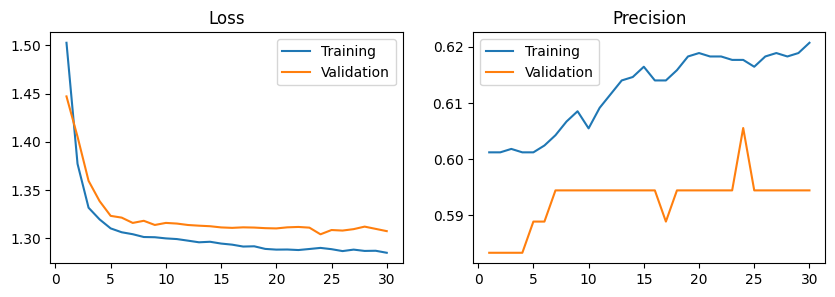

In [118]:
plot_loss_curves(history)

### With data augmentation

In [119]:
model = Network()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = LEARNING_RATE, momentum = 0.9)
hearbetDetectorNetwork = HearbetDetectorTrainer(model = model, device = device)

history = hearbetDetectorNetwork.fit(loss_function = loss_function,
                                     optimizer = optimizer,
                                     epochs = EPOCHS,
                                     batch_size = 10,
                                     training_set = train_dataset_concatenated,
                                     validation_set = test_dataset_concatenated)

Training on cuda
Epoch: 1 | Loss: 1.5936 - Precision: 0.2918 - Val loss: 1.5800 - Val precision: 0.4405
Epoch: 2 | Loss: 1.5255 - Precision: 0.4816 - Val loss: 1.5076 - Val precision: 0.5000
Epoch: 3 | Loss: 1.4720 - Precision: 0.5224 - Val loss: 1.4870 - Val precision: 0.5000
Epoch: 4 | Loss: 1.4372 - Precision: 0.5143 - Val loss: 1.4451 - Val precision: 0.5107
Epoch: 5 | Loss: 1.4348 - Precision: 0.5102 - Val loss: 1.4193 - Val precision: 0.5107
Epoch: 6 | Loss: 1.4169 - Precision: 0.5143 - Val loss: 1.4080 - Val precision: 0.5202
Epoch: 7 | Loss: 1.3977 - Precision: 0.5265 - Val loss: 1.4004 - Val precision: 0.5202
Epoch: 8 | Loss: 1.3896 - Precision: 0.5306 - Val loss: 1.3905 - Val precision: 0.5155
Epoch: 9 | Loss: 1.3845 - Precision: 0.5306 - Val loss: 1.3897 - Val precision: 0.5155
Epoch: 10 | Loss: 1.3739 - Precision: 0.5388 - Val loss: 1.3872 - Val precision: 0.5155
Epoch: 11 | Loss: 1.3718 - Precision: 0.5388 - Val loss: 1.3873 - Val precision: 0.5155
Epoch: 12 | Loss: 1.3729

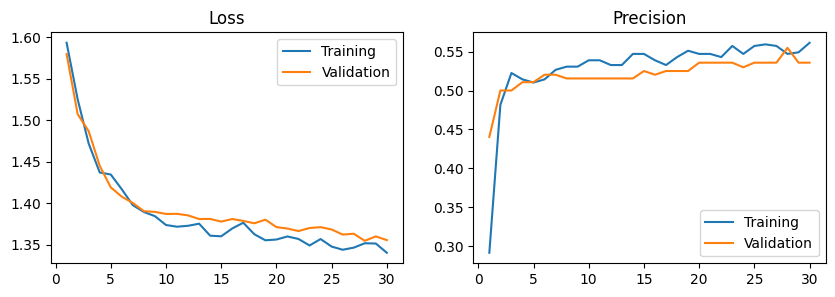

In [120]:
plot_loss_curves(history)

## Training with Pretrained model

In [2]:
class PreTrainedNetwork(nn.Module):
    def __init__(self, model_name: str, num_classes: int) -> None:
        super().__init__()
        self.model = timm.create_model(model_name, pretrained = True, in_chans = 1)
        self.in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p = 0.1),
            nn.Linear(self.in_features, num_classes)
          )

    def forward(self, input):
        return self.model(input)

In [122]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pretrained_model = PreTrainedNetwork(model_name = 'tf_efficientnet_b3_ns', num_classes = 5).to(device)

pretrained_model

c:\Users\Erick\miniconda3\envs\heartbet-sound-anomaly-detector-py311\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


PreTrainedNetwork(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(1, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), 

In [124]:
%%time

class_weights = torch.tensor([0.34, 0.85, 2.83, 2.93, 5.86]).to(device)
LEARNING_RATE: float = 0.05
EPOCHS: int = 8
BATCH_SIZE: int = 8

loss_function = nn.CrossEntropyLoss(weight = class_weights)
optimizer = torch.optim.SGD(params = pretrained_model.parameters(), lr = LEARNING_RATE, momentum = 0.9)

hearbetDetectorNetwork = HearbetDetectorTrainer(model = pretrained_model, device = device)

history = hearbetDetectorNetwork.fit(loss_function = loss_function,
                                     optimizer = optimizer,
                                     epochs = EPOCHS,
                                     batch_size = BATCH_SIZE,
                                     training_set = train_dataset_concatenated,
                                     validation_set = test_dataset_concatenated)

Training on cuda
Epoch: 1 | Loss: 0.8027 - Precision: 0.6352 - Val loss: 1.4874 - Val precision: 0.3750
Epoch: 2 | Loss: 0.8422 - Precision: 0.6025 - Val loss: 1.9282 - Val precision: 0.5048
Epoch: 3 | Loss: 0.7432 - Precision: 0.6619 - Val loss: 1.4463 - Val precision: 0.6298
Epoch: 4 | Loss: 0.7213 - Precision: 0.6537 - Val loss: 1.2377 - Val precision: 0.5337
Epoch: 5 | Loss: 0.5836 - Precision: 0.7561 - Val loss: 1.3757 - Val precision: 0.5962
Epoch: 6 | Loss: 0.7684 - Precision: 0.6598 - Val loss: 1.2517 - Val precision: 0.4904
Epoch: 7 | Loss: 0.5093 - Precision: 0.7561 - Val loss: 2.0937 - Val precision: 0.5096
Epoch: 8 | Loss: 0.5707 - Precision: 0.7377 - Val loss: 1.5988 - Val precision: 0.6538
CPU times: total: 12min 29s
Wall time: 5min 18s


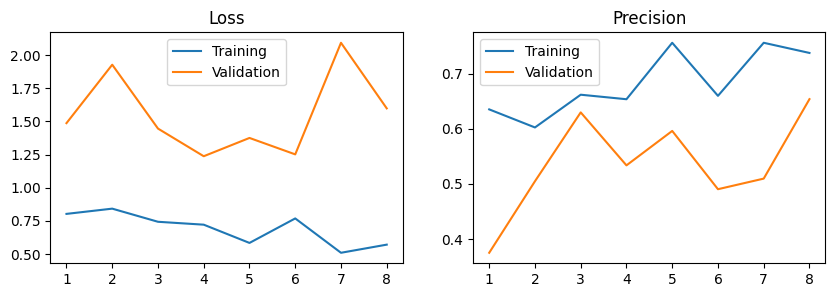

In [125]:
plot_loss_curves(history)

There is a noticeable poor in the model, even when using a pretrained model. This could be attributed to the presence of irrelevant data, as certain classes include audio files with additional sounds recorded alongside them.

## Hearbet sound anomaly detector as a binary classifier

The goal in this new section is to simplify the problem by combining classes that are not "normal", seeking a balanced dataset and better performance in the model.

In [4]:
AUDIO_DIR = Path('../unzipped_data/')

def list_files():
    for file in AUDIO_DIR.glob('**/*.wav'):
        yield file.as_posix()

def create_dataframe():
    data_files = []
    for filename in list_files():
        if any(kewword in filename for kewword in ['artifact', 'extrahls', 'extrastole', 'murmur']):
            data_files.append((filename, 'abnormal'))
        elif filename.find('normal')>-1:
            data_files.append((filename, 'normal'))

    return pd.DataFrame(data_files, columns=('fname', 'label'))

In [5]:
dataframe = create_dataframe()

In [6]:
dataframe.label.value_counts()

label
normal      351
abnormal    234
Name: count, dtype: int64

### Dataset

In [129]:
class AudioDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, *, audio_length: float, target_sample_rate: int) -> None:
        self.__target_sample_rate = target_sample_rate
        self.__num_samples = target_sample_rate * audio_length
        self.__labels = dataframe['label'].values
        self.__filenames = dataframe['fname'].values
        self.__class_indices = {'normal': 0, 'abnormal': 1}

    def __len__(self):
        return len(self.__labels)

    def __getitem__(self, index) -> dict:

        melspec = Preprocessing.process_audio(self.__filenames[index], self.__target_sample_rate, self.__num_samples)

        label: str = self.__labels[index]

        class_idx = self.__class_indices[label]

        return melspec, class_idx

class AudioDatasetWithAugmentation(AudioDataset):

    def __init__(self, dataframe: pd.DataFrame, *, audio_length: float, target_sample_rate: int, transform = None) -> None:

        super().__init__(dataframe, audio_length = audio_length, target_sample_rate = target_sample_rate)

        self.__transform = transform

    def __getitem__(self, index) -> dict:
        melspec, class_idx = super().__getitem__(index)

        melspec = self.__transform(melspec)

        return melspec, class_idx

In [130]:
SEED: int = 42
AUDIO_LENGTH: int = 10
TARGET_SAMPLE_RATE: int = 4000

train_dataset_df, test_dataset_df = train_test_split(dataframe,
                                                     train_size = .7,
                                                     random_state = SEED,
                                                     shuffle = True,
                                                     stratify = dataframe.label)

params = {
    'audio_length': AUDIO_LENGTH,
    'target_sample_rate': TARGET_SAMPLE_RATE
}

train_dataset = AudioDataset(dataframe = train_dataset_df, **params)
test_dataset = AudioDataset(dataframe = test_dataset_df, **params)

transformation_classes = transforms.Compose([
    T.FrequencyMasking(freq_mask_param = 10),
    #T.TimeStretch(.8, fixed_rate = True),
    #T.TimeMasking(time_mask_param = 80)
])

train_dataset_augmented = AudioDatasetWithAugmentation(dataframe = train_dataset_df, **params, transform = transformation_classes)
test_dataset_augmented = AudioDatasetWithAugmentation(dataframe = test_dataset_df, **params, transform = transformation_classes)

train_dataset_concatenated = ConcatDataset((train_dataset, train_dataset_augmented))
test_dataset_concatenated = ConcatDataset((test_dataset, test_dataset_augmented))

In [131]:
len(train_dataset), len(train_dataset_augmented), len(train_dataset_concatenated)

(409, 409, 818)

### Model architecture with binary output

In [132]:
# NUM_CLASSES: 2
# INPUT_SHAPE: (1, 128, 313)

class Network(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 4)),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3)),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 4)),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3)),
            nn.ReLU()
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=(3, 4)),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3)),
            nn.ReLU()
        )

        self.dense_layers = nn.Sequential(
            nn.Linear(128 * 14 * 10, 300),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(300, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, X):
        X = self.conv_block1(X)
        X = self.conv_block2(X)
        X = self.conv_block3(X)
        X = X.view(X.size(0), -1)
        X = self.dense_layers(X)
        return X

In [143]:
class HearbetDetectorTrainer:
    def __init__(self, model, device, model_dir: str) -> None:
        if not isinstance(model, nn.Module):
            raise ValueError('The provided model is not an instance of nn.Module')

        self.__device = device
        self.__precision_fn: Callable = Accuracy(task = 'binary').to(device)
        self.__model = model.to(device)
        self.__model_dir = model_dir

    def __inner_loop(self, specs, labels, loss_function: torch.nn.Module, is_train: bool) -> Tuple:
        specs, labels = specs.to(self.__device), labels.float().to(self.__device)
        outputs = self.__model(specs)
        outputs = torch.sigmoid(outputs).squeeze()
        loss = loss_function(outputs, labels)
        loss_value = loss.item()

        if is_train:
            loss.backward()

        return loss_value, self.__precision_fn(outputs, labels).item()

    def __train_step(self,
                     optimizer: torch.optim.Optimizer,
                     train_loader: torch.utils.data.DataLoader,
                     loss_function: torch.nn.Module,
                     scheduler) -> Tuple[float, float]:

        train_loss, train_accuracy = 0, 0

        self.__model.train()
        for specs, labels in train_loader:
            optimizer.zero_grad()
            loss_value, accuracy_value = self.__inner_loop(specs, labels, loss_function, is_train = True)
            train_loss += loss_value
            train_accuracy += accuracy_value
            optimizer.step()
        scheduler.step()
        length_train_loader = len(train_loader)

        return train_loss/length_train_loader, train_accuracy/length_train_loader

    def __test_step(self, val_loader: torch.utils.data.DataLoader, loss_function: torch.nn.Module) -> Tuple[float, float]:
        val_accuracy, val_loss = 0, 0

        self.__model.eval()
        with torch.inference_mode():
            for specs, labels in val_loader:
                loss_value, accuracy_value = self.__inner_loop(specs, labels, loss_function, is_train = False)
                val_loss += loss_value
                val_accuracy += accuracy_value

        length_val_loader = len(val_loader)

        return val_loss/length_val_loader, val_accuracy/length_val_loader

    def fit(self,
            loss_function: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            epochs: int,
            batch_size: int,
            scheduler,
            training_set,
            validation_set) -> Dict[str, List]:

        print('Training on', self.__device)

        train_loader = DataLoader(training_set, batch_size = batch_size, shuffle = True)
        val_loader = DataLoader(validation_set, batch_size = batch_size)

        report_dict: Dict =  {
            'loss': [],
            'precision': [],
            'val_loss': [],
            'val_precision': []
        }

        for epoch in range(epochs):
            train_loss, train_accuracy = self.__train_step(optimizer, train_loader, loss_function, scheduler)
            val_loss, val_accuracy = self.__test_step(val_loader, loss_function)

            model_name: str = f'epoch_{epoch}_acc={train_accuracy:.4f}_val_acc={val_accuracy:.4f}.pth'
            model_path = Path(self.__model_dir)
            model_path.mkdir(exist_ok = True)
            torch.save(self.__model.cpu().state_dict(), model_path.joinpath(model_name))

            self.__model.to(self.__device)

            report_dict['loss'].append(train_loss)
            report_dict['precision'].append(train_accuracy)
            report_dict['val_loss'].append(val_loss)
            report_dict['val_precision'].append(val_accuracy)

            print('Epoch: {} | Loss: {:.4f} - Accuracy: {:.4f} - Val loss: {:.4f} - Val accuracy: {:.4f}'
                  .format(epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy))

        return report_dict

In [144]:
%%time

device: str = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS: int = 20
BATCH_SIZE: int = 32
LEARNING_RATE: float = 0.001

model = Network()
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = LEARNING_RATE, momentum = 0.9)

hearbetDetectorNetwork = HearbetDetectorTrainer(model = model, device = device, model_dir = 'models_no_backbone')
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

history = hearbetDetectorNetwork.fit(loss_function = loss_function,
                                     optimizer = optimizer,
                                     epochs = EPOCHS,
                                     batch_size = BATCH_SIZE,
                                     scheduler = scheduler,
                                     training_set = train_dataset_concatenated,
                                     validation_set = test_dataset_concatenated)

Training on cuda


c:\Users\Erick\miniconda3\envs\heartbet-sound-anomaly-detector-py311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (65) may be set too low.
  warnings.warn(


Epoch: 1 | Loss: 0.7796 - Accuracy: 0.4080 - Val loss: 0.7793 - Val accuracy: 0.4062
Epoch: 2 | Loss: 0.7712 - Accuracy: 0.4885 - Val loss: 0.7739 - Val accuracy: 0.5000
Epoch: 3 | Loss: 0.7654 - Accuracy: 0.5259 - Val loss: 0.7682 - Val accuracy: 0.5511
Epoch: 4 | Loss: 0.7553 - Accuracy: 0.5779 - Val loss: 0.7610 - Val accuracy: 0.5909
Epoch: 5 | Loss: 0.7506 - Accuracy: 0.6088 - Val loss: 0.7537 - Val accuracy: 0.6023
Epoch: 6 | Loss: 0.7428 - Accuracy: 0.6119 - Val loss: 0.7469 - Val accuracy: 0.6023
Epoch: 7 | Loss: 0.7358 - Accuracy: 0.6115 - Val loss: 0.7407 - Val accuracy: 0.6023
Epoch: 8 | Loss: 0.7312 - Accuracy: 0.6076 - Val loss: 0.7370 - Val accuracy: 0.6023
Epoch: 9 | Loss: 0.7262 - Accuracy: 0.6100 - Val loss: 0.7332 - Val accuracy: 0.6023
Epoch: 10 | Loss: 0.7243 - Accuracy: 0.6100 - Val loss: 0.7293 - Val accuracy: 0.6023
Epoch: 11 | Loss: 0.7210 - Accuracy: 0.6082 - Val loss: 0.7277 - Val accuracy: 0.6023
Epoch: 12 | Loss: 0.7221 - Accuracy: 0.6116 - Val loss: 0.7288 

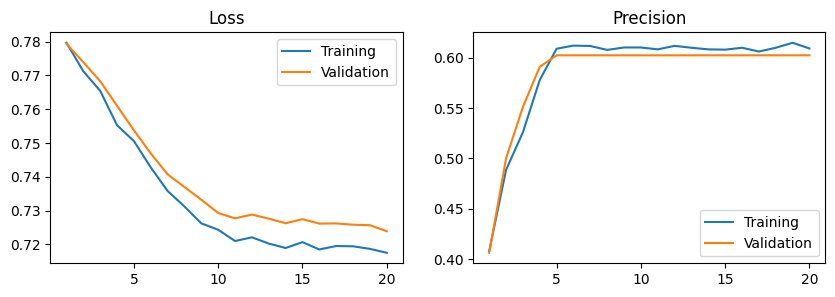

In [145]:
plot_loss_curves(history)

In [146]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pretrained_model = PreTrainedNetwork(model_name = 'tf_efficientnet_b3_ns', num_classes = 1).to(device)

c:\Users\Erick\miniconda3\envs\heartbet-sound-anomaly-detector-py311\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


In [147]:
%%time

LEARNING_RATE: float = 0.05
EPOCHS: int = 7
BATCH_SIZE: int = 32

loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = pretrained_model.parameters(), lr = LEARNING_RATE, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

hearbetDetectorNetwork = HearbetDetectorTrainer(model = pretrained_model, device = device, model_dir = 'models_with_backbone')
history = hearbetDetectorNetwork.fit(loss_function = loss_function,
                                     optimizer = optimizer,
                                     epochs = EPOCHS,
                                     batch_size = BATCH_SIZE,
                                     scheduler = scheduler,
                                     training_set = train_dataset_concatenated,
                                     validation_set = test_dataset_concatenated)

Training on cuda
Epoch: 1 | Loss: 0.7050 - Accuracy: 0.6342 - Val loss: 0.7476 - Val accuracy: 0.5852
Epoch: 2 | Loss: 0.6447 - Accuracy: 0.7452 - Val loss: 0.6504 - Val accuracy: 0.7102
Epoch: 3 | Loss: 0.6231 - Accuracy: 0.8130 - Val loss: 0.6669 - Val accuracy: 0.7273
Epoch: 4 | Loss: 0.6115 - Accuracy: 0.8285 - Val loss: 0.6484 - Val accuracy: 0.7841
Epoch: 5 | Loss: 0.6017 - Accuracy: 0.8560 - Val loss: 0.6366 - Val accuracy: 0.7756
Epoch: 6 | Loss: 0.6021 - Accuracy: 0.8552 - Val loss: 0.6482 - Val accuracy: 0.7301
Epoch: 7 | Loss: 0.5943 - Accuracy: 0.8698 - Val loss: 0.6445 - Val accuracy: 0.7699
CPU times: total: 26min 38s
Wall time: 22min 36s


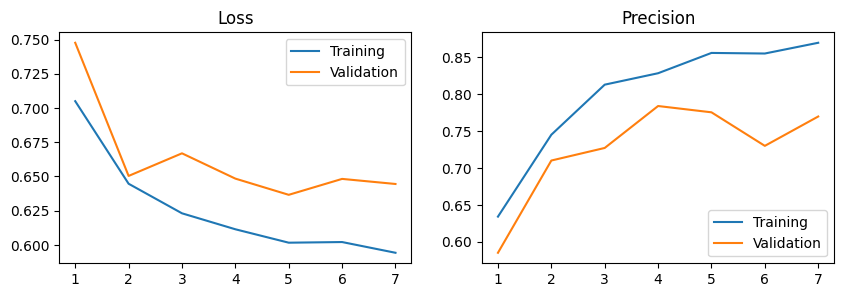

In [148]:
plot_loss_curves(history)

 Conclusions:

 * By turning the model from a multiclass problem to one binary the results improved slighlty.
 * By applying data augmentation the results were more stable.
 * By fine-tunning a pretrained model the validation accuracy was even better, although it took about one hour.

## Inference

In [69]:
input = dataframe.iloc[10]
file_name = input.fname
print('fname', input.fname)
print('label', input.label)

fname ../unzipped_data/set_a/artifact__201106021541.wav
label abnormal


In [70]:
AUDIO_LENGTH: int = 10
TARGET_SAMPLE_RATE: int = 4000
num_samples: int = TARGET_SAMPLE_RATE * AUDIO_LENGTH

melspec = Preprocessing.process_audio(file_name, TARGET_SAMPLE_RATE, num_samples)
melspec = melspec.unsqueeze(0)
print(melspec.size())

torch.Size([1, 1, 128, 313])


c:\Users\Erick\miniconda3\envs\heartbet-sound-anomaly-detector-py311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (65) may be set too low.
  warnings.warn(


In [71]:
MODEL_NAME: str = 'epoch_3_acc=0.8285_val_acc=0.7841.pth'
model_path = Path('models_with_backbone').joinpath(MODEL_NAME)

model = PreTrainedNetwork(model_name = 'tf_efficientnet_b3_ns', num_classes = 1)
model.load_state_dict(torch.load(model_path))
model.eval()

c:\Users\Erick\miniconda3\envs\heartbet-sound-anomaly-detector-py311\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


PreTrainedNetwork(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(1, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), 

In [74]:
logit = model(melspec)
prediction = torch.sigmoid(logit).item()
THRESHOLD: int = 0.5
output = ('abnormal', prediction) if prediction >= THRESHOLD else ('normal', 1 - prediction)
print(output)

('abnormal', 0.9981020092964172)
